     Stock  Stock.1  Stock.2  Stock.3  Stock.4  Stock.5  Stock.6  Stock.7  \
0    22650    81200   178500    32400    75500    41550    78500   146000   
1    22550    82200   178500    32500    74500    40750    78800   147500   
2    22600    82000   177500    32200    71800    40250    78900   145500   
3    23900    86100   187500    33900    75000    42300    82300   152000   
4    23200    86100   179500    34000    78100    42700    82700   151500   
..     ...      ...      ...      ...      ...      ...      ...      ...   
595  38600   148517   277000    38500    83100    31300    70800   130000   
596  40800   152760   282000    40350    88600    31900    72700   134500   
597  38500   153231   282000    41000    88400    31800    73900   137000   
598  38850   153703   281500    41800    89600    31950    74100   137500   
599  39150   154646   280500    40950    89900    31400    73200   136000   

     Stock.8  Stock.9  ...  Stock.89  Stock.90  Stock.91  Stock.92  Stock.9

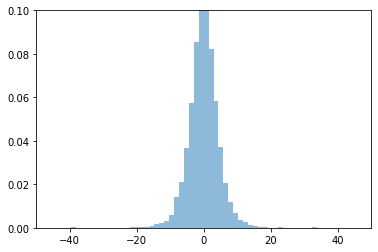

Cluster 1 Summary: 
Cluster Size: 2405 Positive Growth: 45.031185 Average Growth: -2.008440


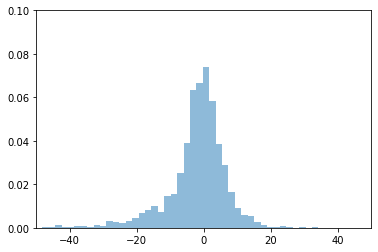

Cluster 2 Summary: 
Cluster Size: 2079 Positive Growth: 41.991342 Average Growth: -0.822450


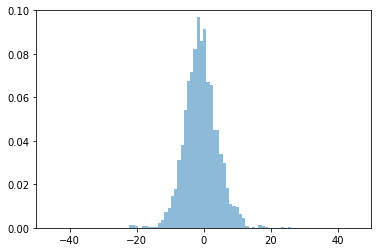

Cluster 3 Summary: 
Cluster Size: 18332 Positive Growth: 50.392756 Average Growth: -0.085527


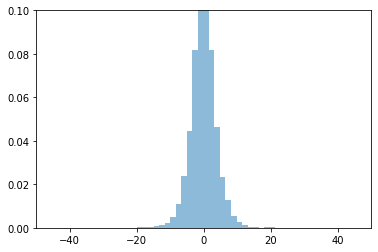

Cluster 4 Summary: 
Cluster Size: 8693 Positive Growth: 49.327045 Average Growth: -0.338963


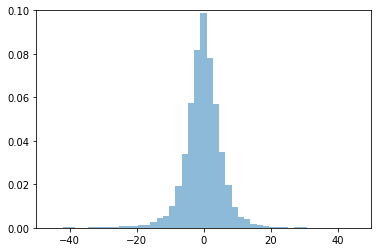

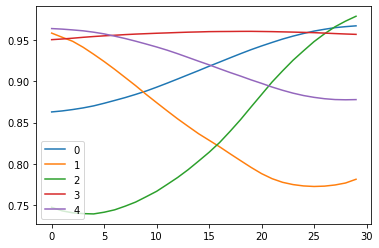

5 clusters for 13419 samples of data using 30 features
Fitting!
Fitting!
Fitting!
Fitting!
Fitting!
No. Features: 30 No. Days: 5 No. Clusters: 5
Cluster Number: 0 Cluster Size: 2869
              precision    recall  f1-score   support

         0.0       0.53      0.51      0.52      1392
         1.0       0.55      0.57      0.56      1477

    accuracy                           0.54      2869
   macro avg       0.54      0.54      0.54      2869
weighted avg       0.54      0.54      0.54      2869


Cluster Number: 1 Cluster Size: 773
              precision    recall  f1-score   support

         0.0       0.60      0.85      0.70       432
         1.0       0.59      0.26      0.36       341

    accuracy                           0.59       773
   macro avg       0.59      0.56      0.53       773
weighted avg       0.59      0.59      0.55       773


Cluster Number: 2 Cluster Size: 684
              precision    recall  f1-score   support

         0.0       0.63      0.75  

In [3]:
import glob, os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

'''
Attempts to see if particular clutsering of price action results in a bias towards a particular 
price action. For example, certain candle formations are said to be associated with certain price 
action. eg. 'Descending/Ascending Triangle', 'wedge', trending up, trending down. etc.

K-means clustering couldn't find significant bullish patterns, but Cluster 4 (downward trending)
has an average growth rate of -1.9%

Then, we use Support Vector Machine (SVM) to prediction price action movement. Best performance was 
Clutser 2 and 4, which had the following:

Cluster Number: 2 Cluster Size: 674
              precision    recall  f1-score   support

         0.0       0.70      0.79      0.74       400
         1.0       0.62      0.51      0.56       274

    accuracy                           0.67       674
   macro avg       0.66      0.65      0.65       674
weighted avg       0.67      0.67      0.67       674

Cluster Number: 4 Cluster Size: 809
              precision    recall  f1-score   support

         0.0       0.57      0.83      0.68       451
         1.0       0.51      0.22      0.31       358

    accuracy                           0.56       809
   macro avg       0.54      0.53      0.49       809
weighted avg       0.55      0.56      0.51       809



'''


def csv_extract(max, min, stock_num, filename = "./KOSPI_DATA.csv",
                verbose = False, checknan = True):
    '''
    Input: Number of samples, Number of Stocks, filename
    Output: numpy array of (number of samples, number of stocks)
    '''
    df = pd.read_csv(filename)
    X = np.zeros((max-min, stock_num))
    count = 0
    for row in df:
        if row[0] == 'S':
            X[:, count] = df[row][min:max]
            count = count + 1
        if count == stock_num:
            break
    if checknan:
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if np.isnan(X[i, j]):
                    raise TypeError("Nan detected at indices " + str((i, j)))
    if verbose:
        print(df, X.shape)
    return X

def data_extract(X_raw, train_max, feature_len, day_num):
    X_train, y_train = np.empty((0, feature_len)), np.empty(0)
    X_test, y_test = np.empty((0, feature_len)), np.empty(0)
    for i in range(train_max):
        for j in range(X_raw.shape[1]):
            pct = 100*(X_raw[i + feature_len, j] - X_raw[i + feature_len + day_num - 1, j]
                     ) / X_raw[i + feature_len, j]  
            X_train = np.vstack((X_train, X_raw[i:i+feature_len, j]/np.max(X_raw[i:i+feature_len, j])))
            y_train = np.append(y_train, pct)

    for i in range(train_max, X_raw.shape[0] - day_num - feature_len):
        for j in range(X_raw.shape[1]):
            try:
                pct = 100*(X_raw[i + feature_len, j] - X_raw[i + feature_len + day_num - 1, j]
                     ) / X_raw[i + feature_len, j]
            except Exception:
                print(i, feature_len, day_num)
            X_test = np.vstack((X_test, X_raw[i:i+feature_len, j]/np.max(X_raw[i:i+feature_len, j])))
            y_test = np.append(y_test, pct)
    return X_train, y_train, X_test, y_test

class StockPredictor:
    def __init__(self, X_train, X_test, y_train, y_test, cluster_num):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = np.random)
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        self.cluster_num = cluster_num
  
    def kmeans_train(self, verbose = True):
        self.X_clust_train, self.y_clust_train = self.kmeans_fit(verbose = verbose,
                                                             train_or_test = 'train')

    def kmeans_test(self, verbose = True):
        self.X_clust_test, self.y_clust_test = self.kmeans_fit(verbose = verbose, train_or_test = 'test')

    def kmeans_fit(self, verbose = False, train_or_test = 'train'):
        cluster_num = self.cluster_num
        if train_or_test == 'train':
            X, y = self.X_train, self.y_train
            self.kmeans = KMeans(n_clusters = cluster_num, init = 'k-means++').fit(X)
            labels = self.kmeans.labels_
        elif train_or_test == 'test':
            X, y = self.X_test, self.y_test
            labels = self.kmeans.predict(X)
        else:
            print('Choose train or test. Returning None')
            return None

        X_clust, y_clust = {}, {}
        for enum, label in enumerate(labels):
            if label not in X_clust:
                y_clust[label] = y[enum]
                X_clust[label] = X[enum]
                continue
            y_clust[label] = np.append(y_clust[label], y[enum])
            X_clust[label] = np.vstack((X_clust[label], X[enum]))    
        if verbose:
            print('%d clusters for %d samples of data using %d features'
                %(cluster_num, enum+1, X.shape[1]))
        return X_clust, y_clust

    def svm_test(self, verbose = False):
        self.y_clust_svm_test = self.get_svm_label(train_or_test = 'test')
        self.X_clust_svm_test = self.get_svm_scaling(train_or_test = 'test')
        for label in range(self.cluster_num):
            clf = self.classifiers[label]
            y_pred, y_true = clf.predict(self.X_clust_svm_test[label]), self.y_clust_svm_test[label]    
            print('Cluster Number: %d Cluster Size: %d' %(label, y_pred.shape[0]))
            print(classification_report(y_true, y_pred))
            print()
        return None
        '''tot_right = 0; tot = 0
        for label in range(self.cluster_num):
          clf = self.classifiers[label]
          y_predict = clf.predict(self.X_clust_svm_test[label])
          if verbose:
            print('CLUSTER %d:' %label)
            print(np.sum(y_predict == self.y_clust_svm_test[label]), y_predict.shape[0], 
                100*np.sum(y_predict == self.y_clust_svm_test[label])/y_predict.shape[0])
          tot_right = tot_right + np.sum(y_predict == self.y_clust_svm_test[label])
          tot = tot + y_predict.shape[0]
        if verbose:
          print('Total Accuracy: %f' %(100*tot_right/tot))''
        return tot_right/tot'''

    def svm_fit(self):
        self.y_clust_svm_train = self.get_svm_label(train_or_test = 'train')
        self.X_clust_svm_train = self.get_svm_scaling(train_or_test = 'train')
        self.classifiers = []
        for key in range(self.cluster_num):
            self.classifiers.append(self.get_svm_classifier(key))

    def get_svm_classifier(self, key, verbose = False):
        #clf = svm.SVC(kernel = 'rbf', gamma = 0.01, C = 100)
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e+0, 1e+1],
                         'C': [1, 10, 100, 1000]}]
        tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
        score = 'recall'
        #clf = GridSearchCV(
        #    SVC(), tuned_parameters, scoring='%s_macro' % score, verbose = 1
        #)
        #clf = SVC(kernel = 'poly', degree = 3, gamma = 1e-2, C = 100)
        clf = SVC(kernel = 'linear', C = 10)
        print('Fitting!')
        clf.fit(self.X_clust_svm_train[key], self.y_clust_svm_train[key])
        if verbose:
            print("Best parameters set found on development set:")
            print(clf.best_params_)
            print("Grid scores on development set:")
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()
        return clf

    def get_svm_label(self, train_or_test = 'train'):
        if train_or_test == 'train':
            X_clust, y_clust = self.X_clust_train, self.y_clust_train
        elif train_or_test == 'test':
            X_clust, y_clust = self.X_clust_test, self.y_clust_test
        else:
            print('Choose train or test. Returning None')
            return None

        y_clust_svm = {}
        for n in range(self.cluster_num):
            y_clust_svm[n] = np.copy(y_clust[n])
            for enum, i in enumerate(y_clust_svm[n]):
                y_clust_svm[n][enum] = 0 if i < 0 else 1
        return y_clust_svm

    def get_svm_scaling(self, train_or_test = 'train'):
        if train_or_test == 'train':
            X_clust, keys = self.X_clust_train, self.X_clust_train.keys()
        elif train_or_test == 'test':
            X_clust, keys = self.X_clust_test, self.X_clust_test.keys()
        else:
            print('Choose train or test. Returning None')
            return None

        X_clust_svm = {}
        for key in keys:
            #X_clust_svm[key] = X_clust[key]
            #continue
            if train_or_test == 'train':
                X_clust_svm[key] = preprocessing.scale(X_clust[key])
            else:
                shape = X_clust[key].shape
                temp = np.vstack((X_clust[key], self.X_clust_train[key]))
                X_clust_svm[key] = preprocessing.scale(temp)
                X_clust_svm[key] = X_clust_svm[key][0:shape[0], 0:shape[1]]
                #X_clust_svm[key] = X_clust[key]
        return X_clust_svm

    def evaluate_clusters(self, plotting = True):
        X_clust = self.X_clust_train
        y_clust = self.y_clust_train  
        X_averages = []
        for n in range(self.cluster_num):
            pos = np.sum(y_clust[n] >= 0)
            print('Cluster %d Summary: \nCluster Size: %d Positive Growth: %f Average Growth: %f' 
            %(n, y_clust[n].shape[0], 100*pos/y_clust[n].shape[0], np.mean(y_clust[n])))
            X_averages.append(np.mean(X_clust[n], axis=0))
            if plotting:
                plt.hist(y_clust[n], 50, density=True, alpha=0.5)
                plt.xlim((-50, 50)); plt.ylim((0, 0.1))
                plt.show()
        if plotting:
            for n in range(self.cluster_num):
                plt.plot(X_averages[n])
        plt.legend(labels = np.arange(0, self.cluster_num))        
        plt.show()

TRAIN_MAX = 300
TEST_MAX = 600
STOCK_NUM_TRAIN = 95
STOCK_NUM_TEST = 10
#(40, 7, 5)
FEATURE_LEN = 30
DAY_NUM = 5
CLUSTER_NUM = 5

SAMPLE_NUM_TEST = TEST_MAX-FEATURE_LEN-DAY_NUM
SAMPLE_NUM_TRAIN = TRAIN_MAX-FEATURE_LEN-DAY_NUM

if __name__ == "__main__":
    filename = './DATA/KOSPI_DATA.csv'
    X_raw = csv_extract(600, 0, STOCK_NUM_TRAIN, verbose = True, filename = filename)
    X_train, y_train, X_test, y_test = data_extract(X_raw, TRAIN_MAX, FEATURE_LEN, DAY_NUM)

    X_train, X_test, y_train, y_test = train_test_split(np.vstack((X_train, X_test)),
                                                np.append(y_train, y_test), random_state = np.random)

    model = StockPredictor(X_train, X_test, y_train, y_test, cluster_num = CLUSTER_NUM)
    model.kmeans_train(verbose = True)
    model.evaluate_clusters()
    model.kmeans_test(verbose = True)
    model.svm_fit()

    print('No. Features: %d No. Days: %d No. Clusters: %d' %(FEATURE_LEN, DAY_NUM, CLUSTER_NUM))
    model.svm_test(verbose = True)